# Imports

In [193]:
import torch
import pandas as pd
import torch.optim as optim
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
# import operator
# from datetime import datetime
from sklearn.model_selection import train_test_split
from utils import *
from models.rnn import *

In [194]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define CUDA

In [195]:
device = 'mps' if torch.cuda.is_available() else 'cpu'

# Load Dataset

In [196]:
#stocks dataset for Altaba Inc
dataset = pd.read_csv('data/bitcoin_final.csv')
display(dataset)
dataset['date'] = dataset['date'].apply(lambda x: string_to_time(x))
bit_value =  dataset[['price']]

,date,price,13.tweets_neg,1.gt_bitcoin,10.news_senti,12.tweets_pos,14.twitter_btccrash_pos,2.gt_Buy_Bitcoin,7.s&p_twitter,8.CBDC_uncertainty,15.twitter_btccrash_neg,6.gt_covid,5.gt_Ukraine_war,9.CBDC_atten,3.gt_Sell_Bitcoin,4.gt_ethereum,11.fear&greed
0,2018-03-01,10929.765497,0.043355,29.428571,0.179275,0.151006,0.215653,19.000000,99.350000,100.940928,0.130917,0.0,0.000000,100.431902,16.000000,12.428571,38.0
1,2018-03-02,11095.091956,0.065677,29.285714,0.162121,0.133858,0.185810,19.000000,99.950000,101.036708,0.146667,0.0,0.000000,100.464187,16.000000,12.285714,47.0
2,2018-03-03,11494.898944,0.050288,29.142857,0.146234,0.138788,0.136385,19.000000,100.296667,101.023647,0.202692,0.0,0.000000,100.439308,16.000000,12.142857,56.0
3,2018-03-04,11516.383566,0.055335,29.000000,0.134706,0.147588,0.162947,19.000000,100.643333,101.010586,0.201579,0.0,0.000000,100.414430,16.000000,12.000000,44.0
4,2018-03-05,11527.568787,0.045240,29.571429,0.124035,0.133230,0.126600,18.857143,100.990000,100.997525,0.172333,0.0,0.000000,100.389551,16.000000,11.857143,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,2022-12-26,16908.948430,0.047236,17.714286,-0.100316,0.103354,0.126526,44.000000,154.027500,102.765109,0.188474,11.0,11.857143,101.536812,9.428571,4.571429,28.0
1762,2022-12-27,16706.459710,0.051911,17.428571,-0.099167,0.121210,0.090167,43.000000,154.050000,102.691097,0.250583,11.0,11.714286,101.472052,9.857143,5.142857,27.0
1763,2022-12-28,16549.983266,0.053312,17.142857,-0.088863,0.105740,0.084077,42.000000,152.360000,102.617084,0.275923,11.0,11.571429,101.407292,10.285714,5.714286,28.0
1764,2022-12-29,16641.444864,0.050335,16.857143,-0.083155,0.123247,0.103692,41.000000,154.400000,102.543072,0.245385,11.0,11.428571,101.342532,10.714286,6.285714,28.0


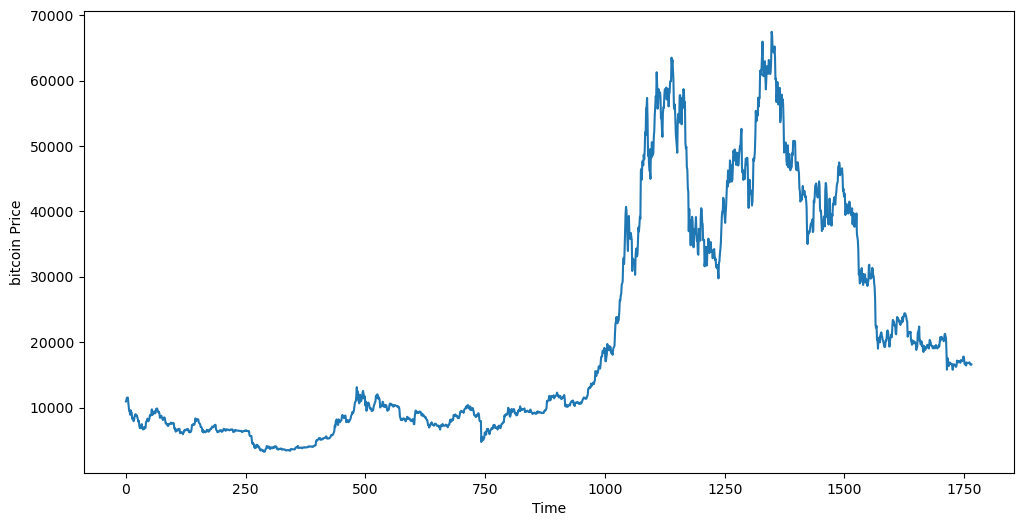

In [197]:
#close value is stock price at the end of that day
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(dataset))), dataset['price'])
plt.xlabel('Time')
plt.ylabel('bitcoin Price')
plt.show()

# Proprocess Dataset

In [198]:
#normalize dataset and keep track of close value
min_max_dictionary = min_max_dic(dataset)
cols = list(dataset.columns.values)
bit_dataset = dataset[[cols[0]]+cols[2:]+[cols[1]]]
display(bit_dataset)

,date,13.tweets_neg,1.gt_bitcoin,10.news_senti,12.tweets_pos,14.twitter_btccrash_pos,2.gt_Buy_Bitcoin,7.s&p_twitter,8.CBDC_uncertainty,15.twitter_btccrash_neg,6.gt_covid,5.gt_Ukraine_war,9.CBDC_atten,3.gt_Sell_Bitcoin,4.gt_ethereum,11.fear&greed,price
0,0.000000,0.155574,0.232919,0.943870,0.433966,0.487902,0.129032,0.123794,0.239365,0.198660,0.00,0.000000,0.132394,0.134021,0.115440,0.366667,0.119712
1,0.000567,0.314442,0.231366,0.924846,0.353774,0.420384,0.129032,0.130298,0.253333,0.222559,0.00,0.000000,0.137405,0.134021,0.113997,0.466667,0.122284
2,0.001133,0.204913,0.229814,0.907228,0.376829,0.308562,0.129032,0.134056,0.251429,0.307576,0.00,0.000000,0.133544,0.134021,0.112554,0.566667,0.128506
3,0.001700,0.240838,0.228261,0.894443,0.417984,0.368659,0.129032,0.137814,0.249524,0.305886,0.00,0.000000,0.129683,0.134021,0.111111,0.433333,0.128840
4,0.002266,0.168987,0.234472,0.882609,0.350837,0.286425,0.127496,0.141572,0.247619,0.261507,0.00,0.000000,0.125822,0.134021,0.109668,0.555556,0.129014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,0.997734,0.183196,0.105590,0.633804,0.211127,0.286259,0.397849,0.716504,0.505397,0.286000,0.11,0.118571,0.303870,0.066274,0.036075,0.255556,0.212754
1762,0.998300,0.216468,0.102484,0.635078,0.294626,0.203997,0.387097,0.716748,0.494603,0.380248,0.11,0.117143,0.293819,0.070692,0.041847,0.244444,0.209603
1763,0.998867,0.226437,0.099379,0.646506,0.222281,0.190219,0.376344,0.698428,0.483809,0.418700,0.11,0.115714,0.283769,0.075110,0.047619,0.255556,0.207168
1764,0.999433,0.205251,0.096273,0.652835,0.304154,0.234598,0.365591,0.720542,0.473016,0.372359,0.11,0.114286,0.273719,0.079529,0.053391,0.255556,0.208591


In [199]:
#split data into training and testing components
from utils import *
x_train, y_train, x_test, y_test = split_data(dataset, 20)
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([1397, 19, 17])
torch.Size([1397])
torch.Size([349, 19, 17])
torch.Size([349])


# Initialize Hyperparameters

In [204]:
input_size = 17
hidden_dim = 30
num_layers = 3
output_dim = 1
epochs = 300

In [205]:
pred = model(x_test)
print(loss_func(pred, y_test.to(device)).item)

<built-in method item of Tensor object at 0x294b8e3f0>


# Define Model (GRU)

In [206]:
model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
loss_func = nn.MSELoss(reduction='mean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [207]:
train_loss = []
min_loss = np.Inf

for epoch in range(epochs):
    #zero out gradients
    optimizer.zero_grad()

    pred = model(x_train.to(device)).squeeze()
    loss = loss_func(pred, y_train.to(device))
    train_loss.append(loss.item())
    print('Epoch {},    Loss: {:.10f}\n'.format(epoch, loss.item()))
    model.eval()
    pred = model(x_test.to(device)).squeeze()
    val_loss = loss_func(pred, y_test.to(device)).item()
    
    #keep track of lowest loss and save as best model
    if val_loss < min_loss:
        print('     train: {:.10f} val Loss: {:.10f} ----> {:.10f}\n'.format(train_loss[-1],min_loss,val_loss ))
        torch.save(model.state_dict(), 'best_model.pt')
        min_loss = val_loss
        model.train()

    #back propogate
    loss.backward()
    optimizer.step()

Epoch 0,    Loss: 0.4836591482

     train: 0.4836591482 val Loss: inf ----> 0.1869015247

Epoch 1,    Loss: 0.4644324183

     train: 0.4644324183 val Loss: 0.1869015247 ----> 0.1743496358

Epoch 2,    Loss: 0.4454544783

     train: 0.4454544783 val Loss: 0.1743496358 ----> 0.1621524990

Epoch 3,    Loss: 0.4265606701

     train: 0.4265606701 val Loss: 0.1621524990 ----> 0.1502063125

Epoch 4,    Loss: 0.4075709283

     train: 0.4075709283 val Loss: 0.1502063125 ----> 0.1384065151

Epoch 5,    Loss: 0.3883394897

     train: 0.3883394897 val Loss: 0.1384065151 ----> 0.1266846657

Epoch 6,    Loss: 0.3687252998

     train: 0.3687252998 val Loss: 0.1266846657 ----> 0.1149836406

Epoch 7,    Loss: 0.3485963047

     train: 0.3485963047 val Loss: 0.1149836406 ----> 0.1032620519

Epoch 8,    Loss: 0.3278428912

     train: 0.3278428912 val Loss: 0.1032620519 ----> 0.0915082097

Epoch 9,    Loss: 0.3063755929

     train: 0.3063755929 val Loss: 0.0915082097 ----> 0.0797451437

Epoch 10,

# Evaluating Model

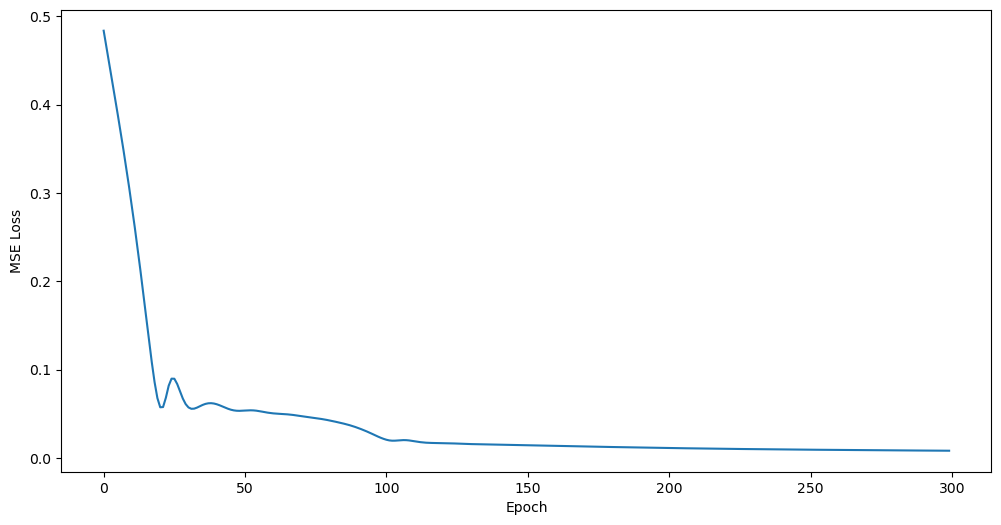

In [208]:
#visualize loss throughout training
plt.figure(figsize=(12, 6))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.plot(list(range(epochs)), train_loss)

# Load the Best Model

In [209]:
best_model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [210]:
#get predictions
lstm_predictions = model(x_test.to(device))
test_loss = loss_func(lstm_predictions.squeeze(), y_test.to(device))
lstm_predictions = lstm_predictions.squeeze().tolist()
print(lstm_predictions)

[0.2071877419948578, 0.2093513309955597, 0.20918744802474976, 0.21059498190879822, 0.2197815477848053, 0.2256462275981903, 0.22790983319282532, 0.2123180329799652, 0.17861077189445496, 0.1425388753414154, 0.12160410732030869, 0.11280562728643417, 0.12175402790307999, 0.14199277758598328, 0.17223772406578064, 0.20611155033111572, 0.2468370795249939, 0.2782585024833679, 0.30003464221954346, 0.30961498618125916, 0.30218926072120667, 0.2910107970237732, 0.29798346757888794, 0.32043421268463135, 0.36955901980400085, 0.42357781529426575, 0.47989562153816223, 0.5208659172058105, 0.5422922372817993, 0.5388576984405518, 0.5208592414855957, 0.494514137506485, 0.47655609250068665, 0.4737260043621063, 0.46532467007637024, 0.41455045342445374, 0.3325713574886322, 0.24913737177848816, 0.17896917462348938, 0.12833210825920105, 0.10114278644323349, 0.08620422333478928, 0.08195023983716965, 0.08437510579824448, 0.0922737643122673, 0.0969867929816246, 0.12956580519676208, 0.1842833161354065, 0.235475450

# Reverse Normalize

In [211]:
min = min_max_dictionary['price'][0]
max = min_max_dictionary['price'][1]

#reverse normalize predictions and dataset values
lstm_predictions = [reverse_normalize(x, min, max) for x in np.array(lstm_predictions)]

# stock_value = [reverse_normalize(x, min, max) for x in np.array(bit_value)]
# print(lstm_predictions)

# Visualizing and Testing Model

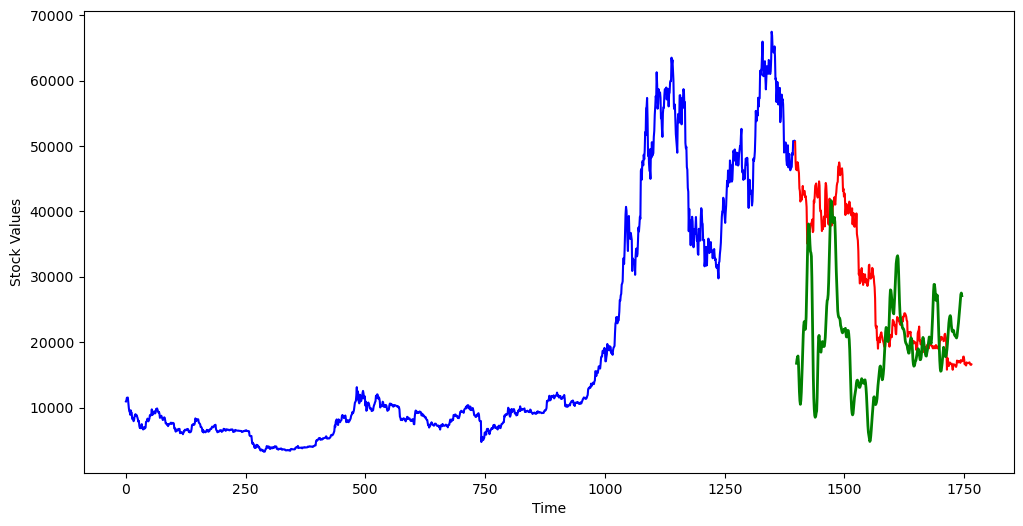

In [212]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(x_train.size(0))], bit_value[:x_train.size(0)], color='b', label='trained values')

#plot test range and predictions by the GRU
time_values_actual = list(range(x_train.size(0), len(bit_value)))
time_values_pred = list(range(x_train.size(0), x_train.size(0) + y_test.size(0)))
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.plot(time_values_actual, bit_value[-len(time_values_actual):], color='r', label='actual values')
plt.plot(time_values_pred[3:], lstm_predictions[3:], color='g', linewidth=2, label='predicted values')

plt.show()